In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib widget

In [3]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
from src.tools.clustering import cluster_hdbscan
from src.models.tfidf import tfidf
from src.tools.dim_reduction import reduce_umap
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl
from src.tools.aggregation import aggregate_hex
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from pytorch_lightning.loggers import WandbLogger
import wandb
from src.models.autoencoder import LitAutoEncoder
import networkx as nx
import osmnx as ox
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import LineGraph

tqdm.pandas()

Speedups enabled: True


In [4]:
place_name = "Wrocław,Poland"
place_dir_name = get_place_dir_name(place_name)
resolution = 9
buffered = False
suffix = get_resolution_buffered_suffix(resolution, buffered)


gpkg_path = GENERATED_DATA_DIR.joinpath(place_dir_name, "graph_drive.gpkg")
hexagons = gpd.read_file(gpkg_path, layer=f"hex_{suffix}").set_index("h3_id")
nodes = gpd.read_file(gpkg_path, layer="nodes")
edges = gpd.read_file(gpkg_path, layer=f"edges_{suffix}")

In [5]:
nodes_preprocessed = nodes.set_index("osmid").drop(columns=["highway", "ref"])
# nodes_preprocessed["highway"] = nodes_preprocessed["highway"].replace("", "None")
# nodes_preprocessed.drop(columns="ref", inplace=True)

# copies of edges exist, because they go through more than one hex -> only one edge can exist with given (u, v, key) for correct graph processing
edges_preprocessed = edges.drop(columns=["h3_id", "id", "geometry"]).groupby(by=["u", "v"]).max().reset_index()
edges_preprocessed["key"] = 0
edges_preprocessed = edges_preprocessed.set_index(["u", "v", "key"])

In [6]:
G_md = ox.graph_from_gdfs(nodes_preprocessed, edges_preprocessed)

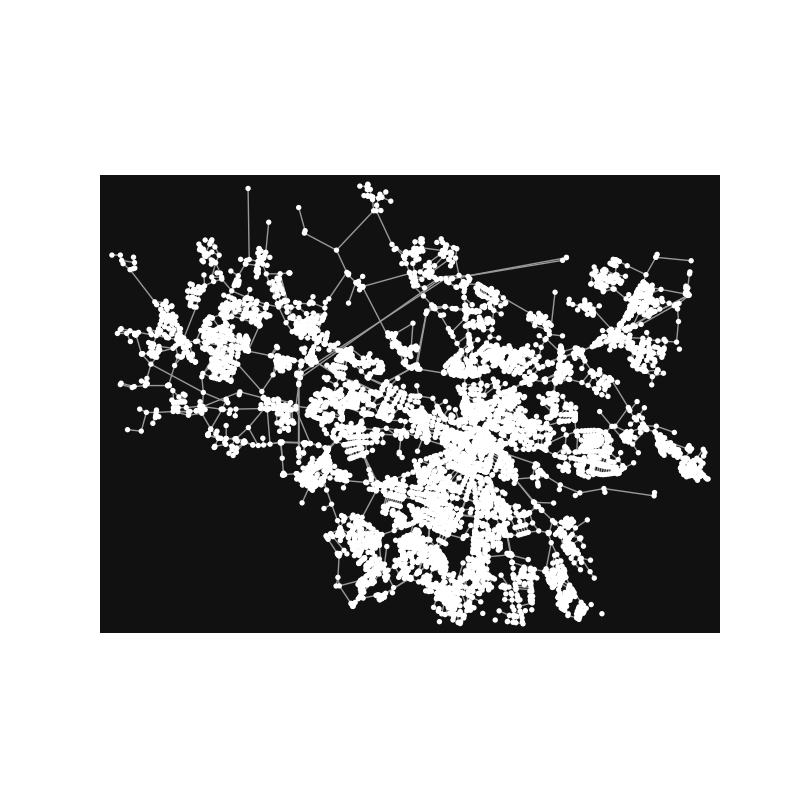

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [7]:
ox.plot.plot_graph(G_md)

In [8]:
group_node_attrs = ["street_count"]
group_edge_attrs = list(edges_preprocessed.columns)
G_d = nx.DiGraph(G_md)
data_node_centric = from_networkx(G_d, group_node_attrs=group_node_attrs, group_edge_attrs=group_edge_attrs)

data_node_centric.pos = torch.tensor(nodes[["x", "y"]].values)
attributes_to_delete = group_node_attrs + group_edge_attrs + ["y"]
for attr in attributes_to_delete:
    data_node_centric.__delattr__(attr)
data_node_centric

Data(x=[7065, 1], edge_index=[2, 9630], edge_attr=[9630, 131], pos=[7065, 2])

In [9]:
data_edge_centric = LineGraph()(data_node_centric.__copy__())
del data_edge_centric.pos
del data_edge_centric.num_nodes
data_edge_centric

Data(x=[9630, 131], edge_index=[2, 8223])

In [12]:
batch_size = 32
shuffle = True
num_workers = 1
X_dl = DataLoader(data_edge_centric, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [13]:
from src.models.autoencoder import LitGAE, GCNEncoder
num_features = data_edge_centric.num_features
out_channels = 64
epochs = 5

wandb_logger = WandbLogger()
run = wandb.init(project="osm-graph-autoencoder", reinit=True)

model = LitGAE(GCNEncoder(num_features, out_channels))
trainer = pl.Trainer(gpus=1, max_epochs=epochs, logger=wandb_logger)
trainer.fit(model, X_dl)

# y = model(X)
# y_df = pd.DataFrame(y.detach().numpy()).add_prefix("x_")
# y_df.index = hex_agg.index

run.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | gae  | GAE  | 25.2 K
------------------------------
25.2 K    Trainable params
0         Non-trainable params
25.2 K    Total params
0.101     Total estimated model params size (MB)
d:\Projekty\Programowanie\Studia\Semestr10\gis\osm-road-infrastructure\venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
d:\Projekty\Programowanie\Studia\Semestr10\gis\osm-road-infrastructure\venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:326: UserWarning: The number of training samples

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

TypeError: 'generator' object is not callable